In [1]:
import sys

cp_dir = '/home/epsilon/workspace/copy-paste-aug'
sys.path.insert(0,cp_dir)

import torch
import utils

batch_size = 2
device = 'cuda' if torch.cuda.is_available else 'cpu'

import albumentations as A
from albumentations.pytorch import ToTensorV2
from copy_paste import CopyPaste

trtf = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.RandomBrightnessContrast(p=0.4),
                A.Resize(700,500),
                CopyPaste(blend=True, sigma=1, pct_objects_paste=1.0, p=1.), #pct_objects_paste is a guess
                A.Normalize(),
                ToTensorV2()
                ], bbox_params=A.BboxParams(format='coco')
                )
                

valtf = A.Compose([
                  A.Normalize(),
                  ToTensorV2()
                  ], bbox_params=A.BboxParams(format='coco')
                    )

tetf = A.Compose([
                  ToTensorV2()
                  ])

from dataset import BCAD_CP_dt
bcad_img = './dotCAD/images'
bcad_ann = './dotCAD/annotations/v1.json'

dataset = BCAD_CP_dt(root=bcad_img,annFile=bcad_ann, mode='train', transforms=trtf)


import torch

trdl = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


ValueError: num_samples should be a positive integer value, but got num_samples=0

In [4]:
checkpoint = True
num_classes = 2

from models import get_instance_segmentation_model
model = get_instance_segmentation_model(num_classes)

########## or 
if checkpoint:
    num_classes = 2

    from models import get_instance_segmentation_model
    model = get_instance_segmentation_model(num_classes)

    import torch
    model_path = './models/mrcnn_cp_v4_400.pth'
    model_dict = torch.load(model_path)
    model.load_state_dict(model_dict['state_dict'])

In [5]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [6]:
from engine import train_one_epoch, evaluate
device='cuda:1'

evaluators = []
model.to(device)
num_epochs = 400
for epoch in range(num_epochs):
    
    print('train =============')
    train_one_epoch(model, optimizer, trdl, device, epoch, print_freq=10)

    lr_scheduler.step()
    # evaluate on the test dataset
    # device = 'cuda:1'
    # model.to(device)
    print('evaluate =============')
    # evaluators.append( evaluate(model, trdl, device=device) )

train =============
Epoch: [0]  [ 0/39]  eta: 0:00:48  lr: 0.000136  loss: 0.5189 (0.5189)  loss_classifier: 0.0811 (0.0811)  loss_box_reg: 0.1001 (0.1001)  loss_mask: 0.3163 (0.3163)  loss_objectness: 0.0157 (0.0157)  loss_rpn_box_reg: 0.0057 (0.0057)  time: 1.2519  data: 0.2188  max mem: 0
Epoch: [0]  [10/39]  eta: 0:00:10  lr: 0.001451  loss: 0.5386 (0.5281)  loss_classifier: 0.0811 (0.0770)  loss_box_reg: 0.0890 (0.0948)  loss_mask: 0.2968 (0.3160)  loss_objectness: 0.0210 (0.0289)  loss_rpn_box_reg: 0.0080 (0.0114)  time: 0.3765  data: 0.0220  max mem: 0
Epoch: [0]  [20/39]  eta: 0:00:06  lr: 0.002765  loss: 0.4831 (0.4988)  loss_classifier: 0.0716 (0.0758)  loss_box_reg: 0.1027 (0.1035)  loss_mask: 0.2410 (0.2919)  loss_objectness: 0.0113 (0.0187)  loss_rpn_box_reg: 0.0072 (0.0088)  time: 0.3373  data: 0.0130  max mem: 0
Epoch: [0]  [30/39]  eta: 0:00:02  lr: 0.004080  loss: 0.4831 (0.5218)  loss_classifier: 0.0711 (0.0769)  loss_box_reg: 0.1001 (0.1032)  loss_mask: 0.2683 (0.315

## model save&load 

In [7]:
model_path = './models/mrcnn_cp_v4_2_400.pth'
torch.save({'state_dict':model.state_dict(),
                'evaluators':evaluators
           },model_path)

In [ ]:
# evaluators visualization

In [6]:
num_classes = 2

from models import get_instance_segmentation_model
model = get_instance_segmentation_model(num_classes)

import torch
model_path = './models/mrcnn_hf_bc_20.pth'
model_dict = torch.load(model_path)
model.load_state_dict(model_dict['state_dict'])

RuntimeError: Error(s) in loading state_dict for MaskRCNN:
	size mismatch for roi_heads.box_predictor.cls_score.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([2, 1024]).
	size mismatch for roi_heads.box_predictor.cls_score.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([2]).
	size mismatch for roi_heads.box_predictor.bbox_pred.weight: copying a param with shape torch.Size([324, 1024]) from checkpoint, the shape in current model is torch.Size([8, 1024]).
	size mismatch for roi_heads.box_predictor.bbox_pred.bias: copying a param with shape torch.Size([324]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for roi_heads.mask_predictor.mask_fcn_logits.weight: copying a param with shape torch.Size([81, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
	size mismatch for roi_heads.mask_predictor.mask_fcn_logits.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([2]).

## vis. 

In [18]:
import argparse
import importlib
import torch
import utils

import os
import sys

import torchvision
from PIL import Image, ImageDraw, ImageFont
import numpy as np

def draw_ann(img,scores,boxes,masks=None,nms=True,iou_threshold=0.5,conf_threshold=0.4 ,mask_threshold=0.5): # pil , tensor,tensor,float

    dis_rgbs = [(230, 25, 75), (60, 180, 75), (255, 225, 25), (0, 130, 200), (245, 130, 48), (145, 30, 180), (70, 240, 240), (240, 50, 230), (210, 245, 60), (250, 190, 212), (0, 128, 128),
        (220, 190, 255), (170, 110, 40), (255, 250, 200), (128, 0, 0), (170, 255, 195), (128, 128, 0), (255, 215, 180), (0, 0, 128), (128, 128, 128), (255, 255, 255), (0, 0, 0)]
    msk  = masks is not None
    size = img.size[::-1]

    # nms
    if nms :
        idx = torchvision.ops.nms(boxes,scores,iou_threshold=0.3)
        boxes  = boxes[idx]
        scores = scores[idx]
        if msk :
            masks = masks[idx]
    if conf_threshold :
        condition = scores>conf_threshold
        boxes  = boxes[condition]
        scores = scores[condition]   
        if msk :
            masks = masks[condition]
    if msk :
        if  'cuda' in masks.device.type:
            masks = masks.clone().detach().cpu()
        summask = np.zeros(size+(3,),dtype='uint8')
        for i,mask in enumerate(masks): 
            condi      = np.array(mask>0.5)
            condi_3    = np.concatenate([condi.reshape(size+(1,) )]*3,axis=2)
            colorMask  = np.array(Image.new('RGB',(size[1],size[0]),dis_rgbs[i]) )
            colorMask  = colorMask * condi_3 

            # multiply 1/2 if overlapped        
#             overlapped = (colorMask.sum(0) * summask.sum(0)).astype('bool')
#             overlapped = np.stack([overlapped,overlapped,overlapped]).reshape( num_condi.shape+(3,))
#             overMask   = colorMask*overlapped//2 + summask*overlapped//2
#             summask    = summask*(~overlapped) + colorMask*(~overlapped)
#             summask    = summask + overMask
            summask    = summask + (colorMask)
        # summask brightness
#         overlapped = 
#         imgnp , summask = np.array(img)[overlapped]//2 + summask[overlapped]//2
        imgnp           = np.array(img)
        img = Image.fromarray(imgnp+summask ) 
    
    annimg = img.copy()
    draw = ImageDraw.Draw(annimg)
    font = ImageFont.load_default()
    
    for i,box in enumerate(boxes):
        # draw.rectangle(xy=[0,0,150,150],outline=dis_rgb[2] )#, outline=label_color_map[det_labels[i]])
        box_xy = box.tolist()
        draw.rectangle(xy=box_xy,outline=dis_rgbs[i%len(dis_rgbs)] )#, outline=label_color_map[det_labels[i]])
        title = str(round(scores[i].item(),4))
        draw.text(xy=[box_xy[0]+len(title),box_xy[1]-1],text=title,fill='white',font=font)
    del draw
        
    
    return annimg

In [ ]:
# file > pil > tensor
from PIL import Image
from torchvision.transforms import functional as vfc 
img     = Image.open(args.input).convert('RGB')

imgt    = vfc.to_tensor(img).to(device = device)

In [43]:
# tensor > 
idx = 4
x,y  = dataset_test[idx]

import torchvision.transforms as T

img = T.ToPILImage()(imgt).convert('RGB')
imgt = x.to(device = device)

model.eval()
pre     = model([imgt])

# draw prediction annotation (Mask ,Bbox ,score)
annimg = draw_ann(img,pre[0]['scores'].cpu(),pre[0]['boxes'].cpu(),pre[0]['masks'].cpu(),nms=True,conf_threshold=0.4)

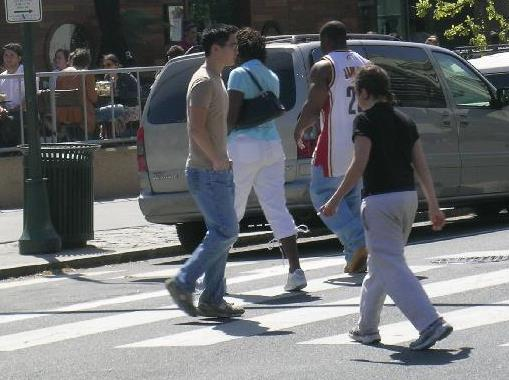

In [45]:
img

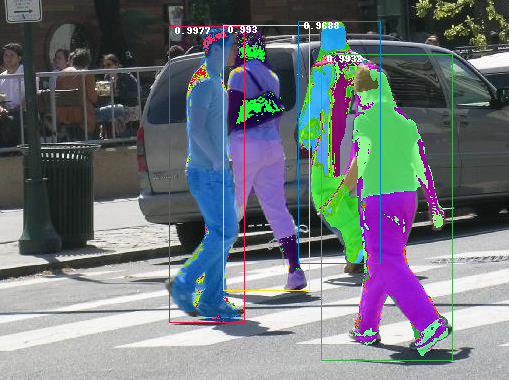

In [44]:
annimg

In [27]:
annimg.save('result.png')

In [16]:
def decorator_function(original_function):
    def wrapper_function():
        print('{} 함수가 호출되기전 입니다.'.format(original_function.__name__))
        return original_function()

    return 2# wrapper_function


@decorator_function  # 1
class asd():
    def display_1():
        print('display_1 함수가 실행됐습니다.')
    def __call__(self):
        print('asdf')

@decorator_function  # 2
def display_2():
    print('display_2 함수가 실행됐습니다.')

In [17]:
asd

2